In [1]:
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve

/eos/user/l/lcondren/miniconda3/envs/exatrkx-gpu2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_data(events, pt_background_cut, pt_signal_cut, noise):
    # Handle event in batched form
    if type(events) is not list:
        events = [events]

    # NOTE: Cutting background by pT BY DEFINITION removes noise
    if (pt_background_cut > 0) or not noise:
        for event in events:

            edge_mask = ((event.pt[event.edge_index] > pt_background_cut) & (event.pid[event.edge_index] == event.pid[event.edge_index]) & (event.pid[event.edge_index] != 0)).all(0)
            event.edge_index = event.edge_index[:, edge_mask]
            event.y = event.y[edge_mask]

            if "weights" in event.__dict__.keys():
                if event.weights.shape[0] == edge_mask.shape[0]:
                    event.weights = event.weights[edge_mask]

            if "y_pid" in event.__dict__.keys():
                event.y_pid = event.y_pid[edge_mask]

    for event in events:
        if "y_pid" not in event.__dict__.keys():
            event.y_pid = (event.pid[event.edge_index[0]] == event.pid[event.edge_index[1]]) & event.pid[event.edge_index[0]].bool()

        if (
            "signal_true_edges" in event.__dict__.keys()
            and event.signal_true_edges is not None
        ):
            signal_mask = (
                event.pt[event.signal_true_edges] > pt_signal_cut
            ).all(0)
            event.signal_true_edges = event.signal_true_edges[:, signal_mask]   

    return events



def load_dataset(input_subdir,
    num_events=10,
    pt_background_cut=0,
    pt_signal_cut=0,
    noise=False,
    **kwargs):
    if input_subdir is not None:
        all_events = os.listdir(input_subdir)
        all_events = sorted([os.path.join(input_subdir, event) for event in all_events])
        loaded_events = [
            torch.load(event, map_location=torch.device("cpu"))
            for event in all_events[:num_events]
        ]
        loaded_events = select_data(
            loaded_events, pt_background_cut, pt_signal_cut, noise
        )
        return loaded_events
    else:
        return None



## test cell. figure out why indexing stops around 7

In [7]:
signal_pid = 15
purity = []
efficiency = []
input_subdir = 'quickstart_metric_learning_processed/test'
print(len(os.listdir(input_subdir)))
loaded_events = load_dataset(input_subdir=input_subdir, num_events=len(os.listdir(input_subdir)) + 10, pt_background_cut=0, pt_signal_cut=0, noise=False)
print(max(loaded_events[0].edge_index[1]))
for event in loaded_events:
    display(event.x)    
    particle_df = pd.read_csv(event.event_file + '-particles.csv')
    particle_df = particle_df[particle_df['PID'] == signal_pid]
    selected_pid = particle_df['particle_id'].values[0]
    pid_df = pd.DataFrame(event.pid.numpy(), columns=['pid']).reset_index(drop=True)
    edge_df = pd.DataFrame(event.edge_index.numpy().T, columns=['source', 'target'])
    truth_edge_df = pd.DataFrame(event.signal_true_edges.numpy().T, columns=['source', 'target'])
    selected_edges = edge_df[pid_df.pid[edge_df.source].values == selected_pid]
    selected_truth_edges = truth_edge_df[pid_df.pid[truth_edge_df.source].values == selected_pid]
    print(selected_pid)
    display(selected_edges)
    display(selected_truth_edges)
    break

491
tensor(1400)


tensor([[ 0.0603, -0.0539,  0.1212],
        [ 0.1008, -0.0901,  0.2027],
        [ 0.1412, -0.1264,  0.2845],
        ...,
        [ 0.2626, -0.0139, -0.0541],
        [ 0.3030, -0.0160, -0.0625],
        [ 0.3435, -0.0181, -0.0708]])

706.0


,source,target
1365,813,814
1366,814,815
1367,816,815
1368,816,817
1369,818,817
1370,819,818
1371,819,820


,source,target
708,813,814
709,814,815
710,815,816
711,816,817
712,817,818
713,818,819
714,819,820


In [6]:
signal_pid = 15
purity = []
efficiency = []
input_subdir = 'quickstart_metric_learning_processed/test'
print(len(os.listdir(input_subdir)))
loaded_events = load_dataset(input_subdir=input_subdir, num_events=len(os.listdir(input_subdir)) + 10, pt_background_cut=0, pt_signal_cut=0, noise=False)
for event in loaded_events:    
    particle_df = pd.read_csv(event.event_file + '-particles.csv')
    particle_df = particle_df[particle_df['PID'] == signal_pid]
    selected_pid = particle_df['particle_id'].values[0]
    pid_df = pd.DataFrame(event.pid.numpy(), columns=['pid']).reset_index(drop=True)
    edge_df = pd.DataFrame(event.edge_index.numpy().T, columns=['source', 'target'])
    truth_edge_df = pd.DataFrame(event.signal_true_edges.numpy().T, columns=['source', 'target'])
    selected_edges = edge_df[pid_df.pid[edge_df.source].values == selected_pid]
    selected_truth_edges = truth_edge_df[pid_df.pid[truth_edge_df.source].values == selected_pid]
    #display(selected_edges)
    # display(selected_truth_edges)

    # Find and print the number of common edges
    # Ensure the order of source and target does not matter by sorting the columns
    selected_edges_sorted = selected_edges.apply(lambda row: sorted([row['source'], row['target']]), axis=1, result_type='expand')
    selected_edges_sorted.columns = ['source', 'target']

    selected_truth_edges_sorted = selected_truth_edges.apply(lambda row: sorted([row['source'], row['target']]), axis=1, result_type='expand')
    selected_truth_edges_sorted.columns = ['source', 'target']

    common_edges = pd.merge(selected_edges_sorted, selected_truth_edges_sorted, on=['source', 'target'])
    #print(f"Number of common edges: {len(common_edges)}")

    pur = len(common_edges) / max(1,len(selected_edges))
    eff = len(common_edges) / max(1, len(selected_truth_edges))

    purity.append(pur)
    efficiency.append(eff)
    # print(f"Purity: {pur}")
    # print(f"Efficiency: {eff}")

print(purity)
print(efficiency)

491


Data(x=[1401, 3], pid=[1401], event_file='Examples/QuirkTracking/Scripts/Train_SM_test_mix_split_1500_500/event100001509', hid=[1401], pt=[1401], modulewise_true_edges=[2, 1221], layerwise_true_edges=[2, 1221], signal_true_edges=[2, 1221], edge_index=[2, 2378], y=[2378], y_pid=[2378])
[]
[]


## Test 1

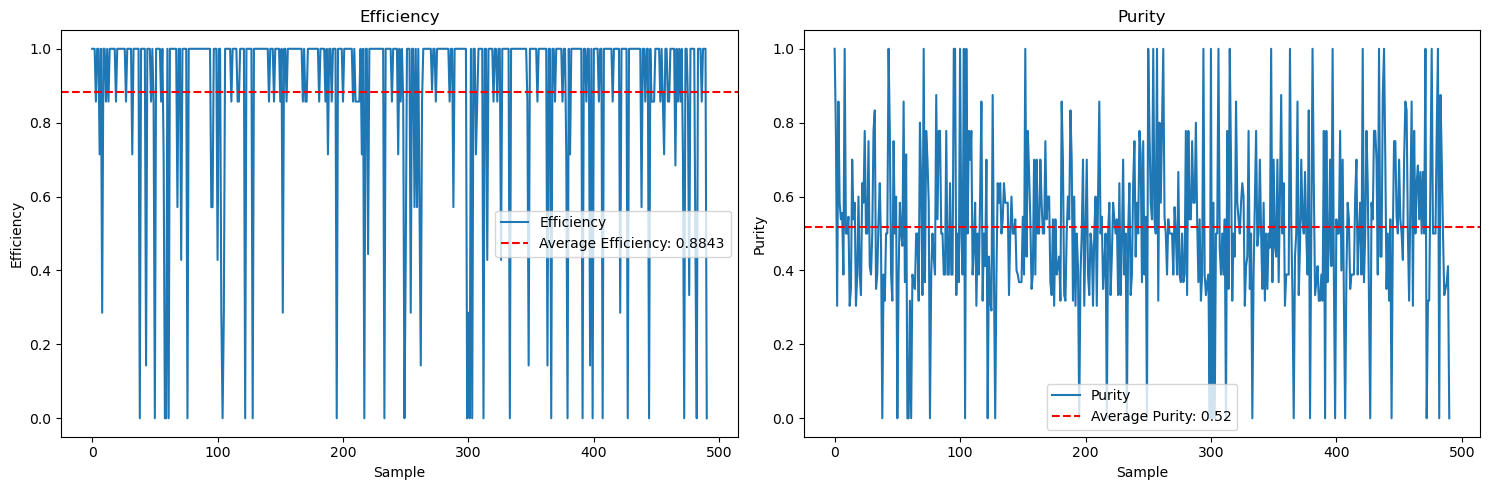

In [4]:
# Plot Efficiency vs Sample
efficiency = np.array(efficiency)
purity = np.array(purity)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(efficiency, label='Efficiency')
avg_efficiency = efficiency.mean()
axs[0].axhline(y=avg_efficiency, color='r', linestyle='--', label=f'Average Efficiency: {avg_efficiency:.4f}')
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Efficiency')
axs[0].set_title('Efficiency')
axs[0].legend()

# Plot Purity vs Sample
axs[1].plot(purity, label='Purity')
avg_purity = purity.mean()
axs[1].axhline(y=avg_purity, color='r', linestyle='--', label=f'Average Purity: {avg_purity:.2f}')
axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Purity')
axs[1].set_title('Purity')
axs[1].legend()

plt.tight_layout()
plt.show()

## Test 2

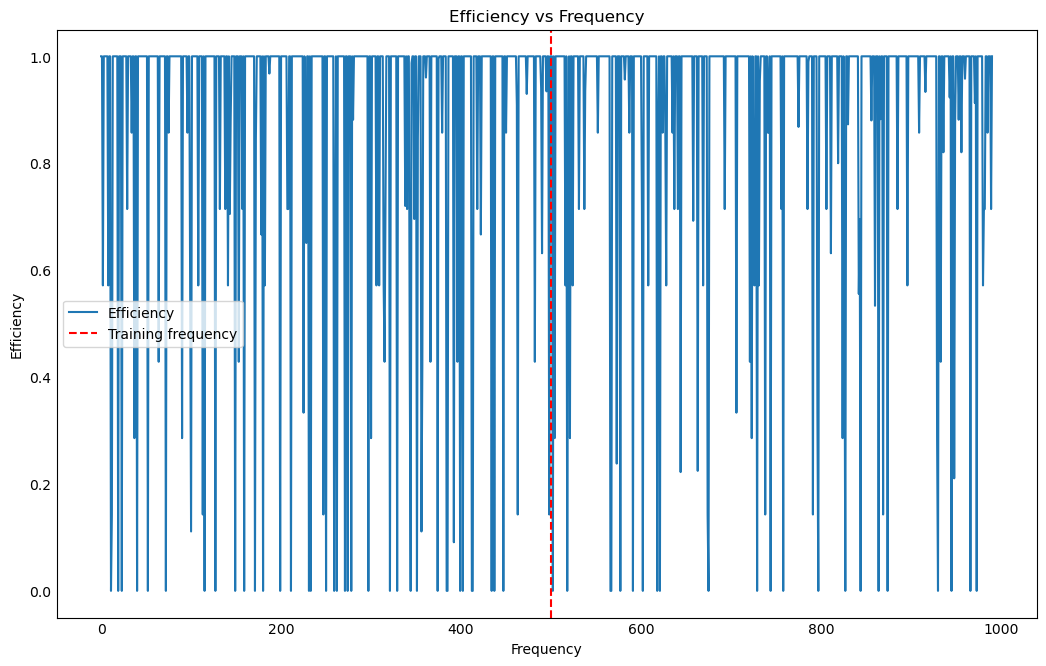

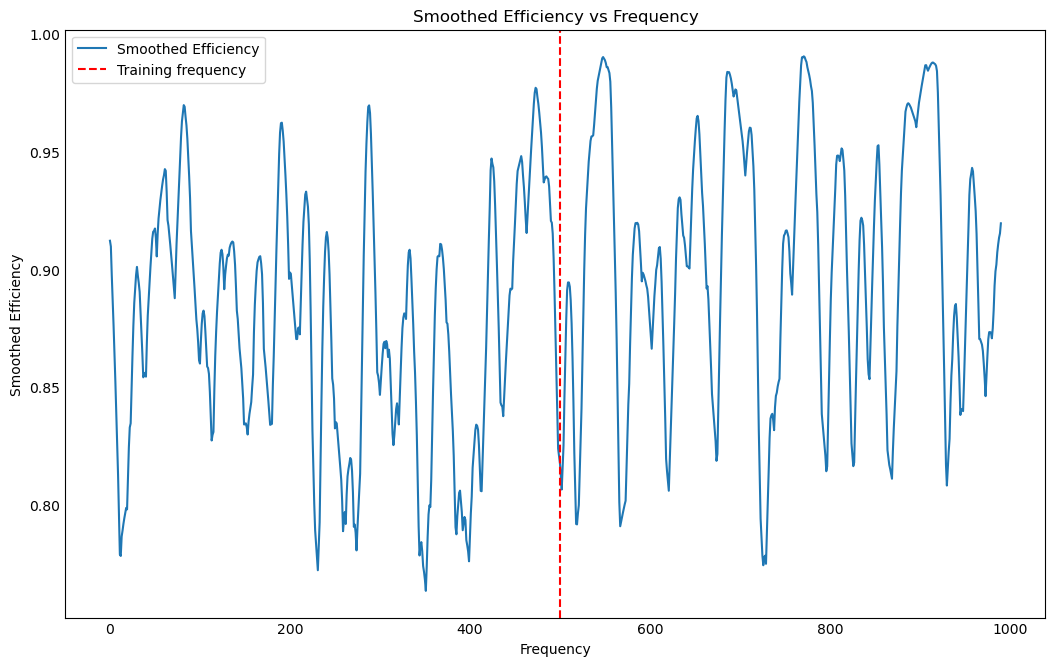

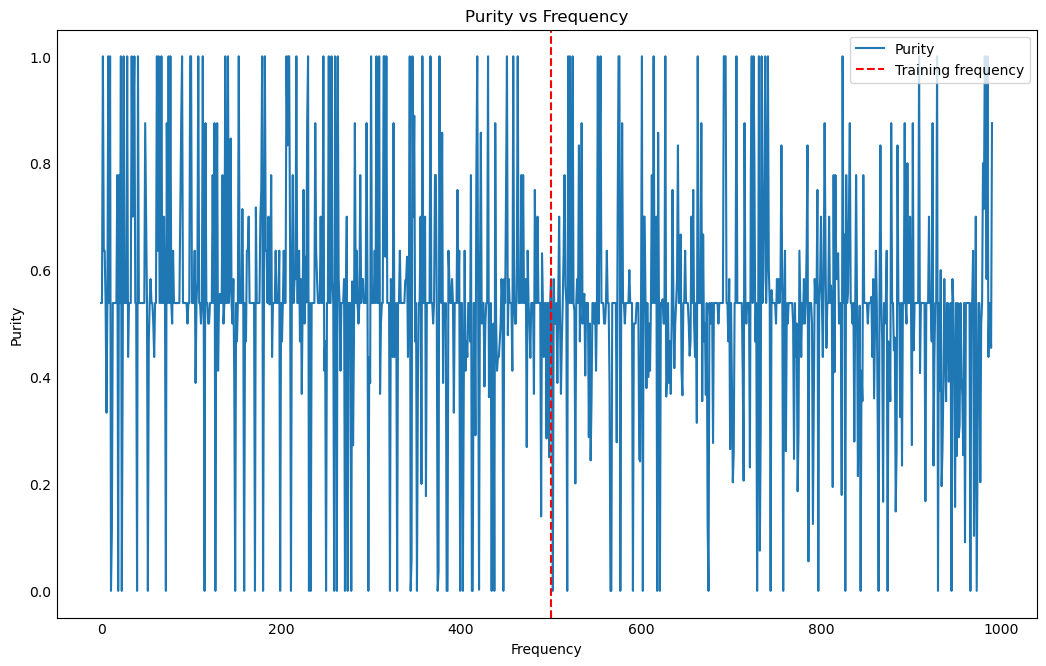

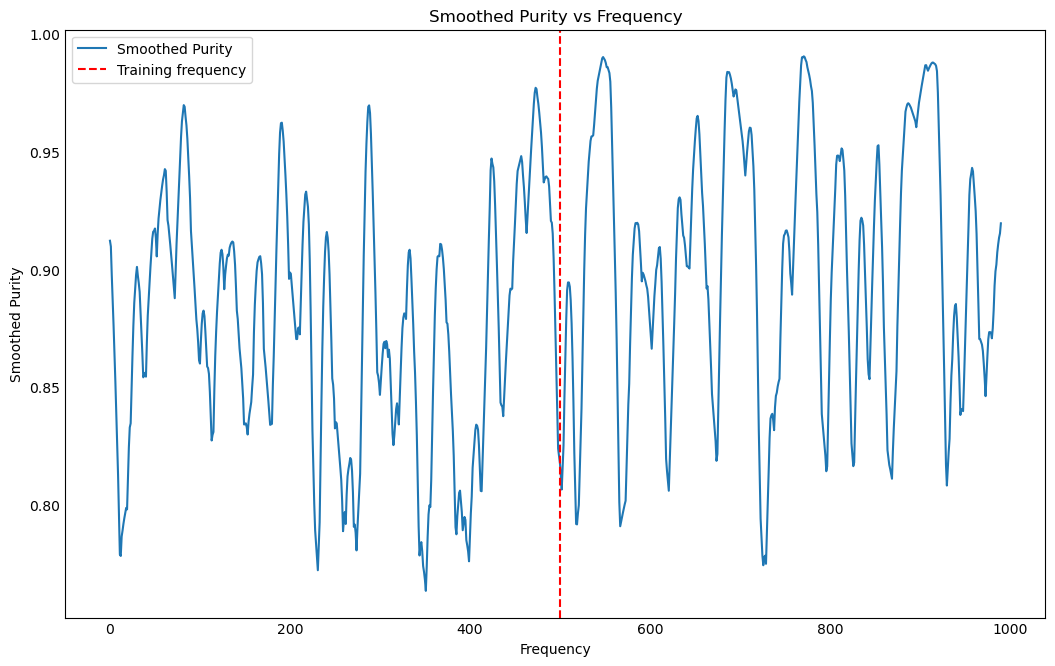

In [24]:
# Plot one of the columns against the index
plt.figure(figsize=(10, 6))
plt.plot(efficiency, label='Efficiency')
plt.axvline(x=500, color='r', linestyle='--', label='Training frequency')
plt.xlabel('Frequency')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Frequency')
plt.legend()
plt.show()

kernel = np.array([0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2, 1.8, 1.6, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.08, 0.04, 0.02, 0.01])
kernel = kernel / kernel.sum()

smoothed_efficiency = convolve(efficiency, kernel, mode='reflect')

# Plot the smoothed efficiency
plt.figure(figsize=(10, 6))
plt.plot(smoothed_efficiency, label='Smoothed Efficiency')

plt.axvline(x=500, color='r', linestyle='--', label='Training frequency')
plt.xlabel('Frequency')
plt.ylabel('Smoothed Efficiency')
plt.title('Smoothed Efficiency vs Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(purity, label='Purity')
plt.axvline(x=500, color='r', linestyle='--', label='Training frequency')
plt.xlabel('Frequency')
plt.ylabel('Purity')
plt.title('Purity vs Frequency')
plt.legend()
plt.show()

kernel = np.array([0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2, 1.8, 1.6, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.08, 0.04, 0.02, 0.01])
kernel = kernel / kernel.sum()

smoothed_efficiency = convolve(efficiency, kernel, mode='reflect')

# Plot the smoothed efficiency
plt.figure(figsize=(10, 6))
plt.plot(smoothed_efficiency, label='Smoothed Purity')

plt.axvline(x=500, color='r', linestyle='--', label='Training frequency')
plt.xlabel('Frequency')
plt.ylabel('Smoothed Purity')
plt.title('Smoothed Purity vs Frequency')
plt.legend()
plt.show()


## Test 3

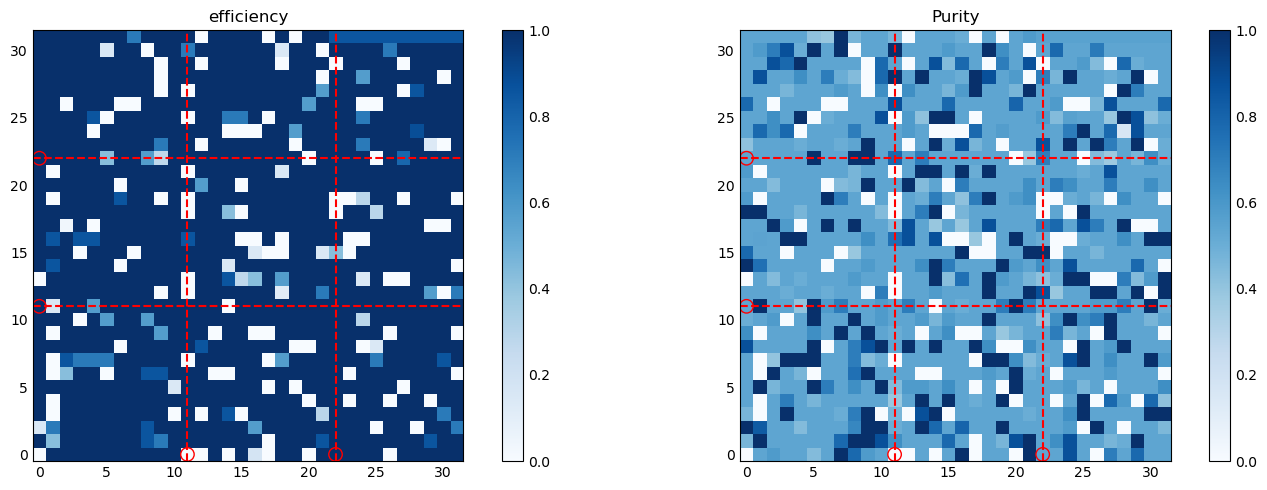

<Figure size 200x200 with 0 Axes>

In [21]:
purity = np.array(purity)
average_purity = np.mean(purity)
purity = np.append(purity, [average_purity] * 10)
efficiency = np.array(efficiency)
efficiency = np.append(efficiency, [np.mean(efficiency, axis=0)] * 10, axis=0)
purity = purity.reshape(32,32)
efficiency = efficiency.reshape(32,32)
plt.style.use('_mpl-gallery-nogrid')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loop through the subplots
for i, ax in enumerate(axs):
    # Get the data for the current subplot
    if i == 0:
        z = efficiency
        title = 'efficiency'
    elif i == 1:
        z = purity
        title = 'Purity'
    
    # Plot the data
    im = ax.imshow(z, origin='lower')
    ax.set_title(title)
    ax.axvline(x=11, color='r', linestyle='--', label='Training frequency')
    ax.axvline(x=22, color='r', linestyle='--')
    ax.axhline(y=11, color='r', linestyle='--')
    ax.axhline(y=22, color='r', linestyle='--')
    ax.add_patch(plt.Circle((0, 11), 0.5, color='r', fill=False))  # Add the circle patch
    ax.add_patch(plt.Circle((0, 22), 0.5, color='r', fill=False))
    ax.add_patch(plt.Circle((11, 0), 0.5, color='r', fill=False))
    ax.add_patch(plt.Circle((22, 0), 0.5, color='r', fill=False))
    # Add color legend
    cbar = plt.colorbar(im, ax=ax)

# Show the subplots
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

In [20]:
input_subdir = 'quickstart_gnn_processed/train'
loaded_events = load_dataset(input_subdir=input_subdir, num_events=10, pt_background_cut=0, pt_signal_cut=0, noise=False)

for event in loaded_events:
    df = pd.DataFrame(event.pid)
    display(df)
    break

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1


,0
0,2
1,2
2,2
3,2
4,2
5,2
6,2
7,2


,0
0,3
1,3
2,3
3,3
4,3
5,3
6,3
7,3


,0
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4


,0
0,5
1,5
2,5
3,5
4,5
...,...
69,5
70,5
71,5
72,5


,0
0,6
1,6
2,6
3,6
4,6
5,6
6,6
7,6


,0
0,7
1,7
2,7
3,7
4,7
5,7
6,7
7,7


,0
0,8
1,8
2,8
3,8
4,8
5,8
6,8
7,8


,0
0,9
1,9
2,9
3,9
4,9
5,9
6,9
7,9


,0
0,10
1,10
2,10
3,10
4,10
5,10
6,10
7,10
